# ResNet: Deep Residual Learning for Image Recognition

### Imports

In [4]:
import tensorflow as tf
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from keras.layers import Layer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import h5py
import numpy as np

In [5]:
print(tf.__version__)

2.17.1


## Prepare the Dataset: Finger Signs Dataset

In [6]:
def load_dataset():
    train_dataset = h5py.File("/kaggle/input/signs-detection-dataset/Signs_Data_Training.h5", "r")
    # train set features
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    # train set labels
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File("/kaggle/input/signs-detection-dataset/Signs_Data_Testing.h5", "r")
    # test set features
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    # test set labels
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    # the list of classes
    classes = np.array(test_dataset["list_classes"][:])

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [7]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

x_train_orig, y_train_orig, x_test_orig, y_test_orig, classes = load_dataset()

# Normalize image vectors
x_train = x_train_orig / 255.
x_test = x_test_orig / 255.

# Convert training and test labels to one hot matrices
y_train = convert_to_one_hot(y_train_orig, 6).T
y_test = convert_to_one_hot(y_test_orig, 6).T

print ("number of training examples = " + str(x_train.shape[0]))
print ("number of test examples = " + str(x_test.shape[0]))
print ("x_train shape: " + str(x_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("x_test shape: " + str(x_test.shape))
print ("y_test shape: " + str(y_test.shape))

number of training examples = 1080
number of test examples = 120
x_train shape: (1080, 64, 64, 3)
y_train shape: (1080, 6)
x_test shape: (120, 64, 64, 3)
y_test shape: (120, 6)


In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [9]:
print(len(x_train), len(x_val), len(x_test))

864 216 120


In [13]:
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(100, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(-1)

In [14]:
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.repeat()

In [15]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.repeat()

## Define the Model

### Custom BatchNorm

In [16]:
class BatchNormalization(Layer):
    def __init__(self, axis=-1, momentum=0.90, name=None, synchronized=False, **kwargs):
        super().__init__(name=name, **kwargs)
        self.axis = axis
        self.momentum = momentum

    def build(self, input_shape):
        param_shape = (input_shape[self.axis],)  # Ensure shape is a tuple

        self.beta = self.add_weight(
            name="beta",
            shape=param_shape,
            initializer="zeros",
            trainable=True,
        )
        self.gamma = self.add_weight(
            name="gamma",
            shape=param_shape,
            initializer="ones",
            trainable=True,
        )
        self.moving_mean = self.add_weight(
            name="moving_mean",
            shape=param_shape,
            initializer=tf.initializers.zeros(),
            trainable=False,
        )
        self.moving_variance = self.add_weight(
            name="moving_variance",
            shape=param_shape,
            initializer=tf.initializers.ones(),
            trainable=False,
        )

        super().build(input_shape)  # Ensures proper weight tracking

    def get_moving_average(self, statistic, new_value):
        return statistic * self.momentum + new_value * (1 - self.momentum)

    def normalise(self, x, x_mean, x_var):
        return (x - x_mean) / tf.sqrt(x_var + 1e-6)

    def call(self, inputs, training=False):
        if training:
            axes = [0, 1, 2] if len(inputs.shape) > 2 else [0]
            mean, var = tf.nn.moments(inputs, axes=axes, keepdims=False)

            # Update moving averages
            self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
            self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
        else:
            mean, var = self.moving_mean, self.moving_variance

        x = self.normalise(inputs, mean, var)
        return self.gamma * x + self.beta

### Identity Block

<div align="center">

  <img alt="Identity Block" src="assets/identity_block_skip3.png" width=800 height=250/>
  <br/>
  <figcaption>Figure 1: Identity Block. Skip connection: skips over 3 layers</figcaption>

</div>

In [17]:

def identity_block(inputs, f, filters, initializer=random_uniform, training=False):
    """
    Identity block that skips over 3 layers

    Args:
        inputs (tensor): input tensor of shape (b, H, W, C)
        f (int): the shape of the middle Conv's window for the main path
        filters (List[int]): number of filters

    Returns:
        output of the identity block, tensor of shape (b, H, W, C)
    """

    # retrieve filters
    f1, f2, f3 = filters

    # save input value
    input_shortcut = inputs

    # 1st component of the main path
    x = tf.keras.layers.Conv2D(
        filters=f1,
        kernel_size=1,
        strides=(1, 1),
        padding="valid",
        kernel_initializer=initializer(seed=0),
    )(inputs)
    x = BatchNormalization(axis=3)(x, training=training)
    x = tf.keras.layers.Activation("relu")(x)

    # 2nd component
    x = tf.keras.layers.Conv2D(
        filters=f2,
        kernel_size=f,
        strides=(1, 1),
        padding="same",
        kernel_initializer=initializer(seed=0),
    )(x)
    x = BatchNormalization(axis=3)(x, training=training)
    x = tf.keras.layers.Activation("relu")(x)

    # 3rd component
    x = tf.keras.layers.Conv2D(
        filters=f3,
        kernel_size=1,
        strides=(1, 1),
        padding="valid",
        kernel_initializer=initializer(seed=0),
    )(x)
    x = BatchNormalization(axis=3)(x, training=training)

    # final step: add shortcut value to main path, and pass it through a ReLU
    x = tf.keras.layers.Add()([x, input_shortcut])
    x = tf.keras.layers.Activation("relu")(x)

    return x

### Convolutional Block


<div align="center">

  <img alt="Convolutional Block" src="assets/convolutional_block_skip3.png" width=800 height=250/>
  <br/>
  <figcaption>Figure 2: Convolutional Block</figcaption>

</div>

In [18]:
def convolutional_block(inputs, f, filters, s=2, initializer=glorot_uniform, training=False):
    """
    Convolutional block that skips over 3 layers

    Args:
        inputs (tensor): input tensor of shape (b, H, W, C)
        f (int): the shape of the middle Conv's window for the main path
        filters (List[int]): number of filters
        s (int): stride value

    Returns:
        output of the convolutional block, tensor of shape (b, H, W, C)
    """

    # retrieve filters
    f1, f2, f3 = filters

    # save input value
    input_shortcut = inputs

    # 1st component of main path
    x = tf.keras.layers.Conv2D(
        filters=f1,
        kernel_size=1,
        strides=(s, s),
        padding="valid",
        kernel_initializer=initializer(seed=0),
    )(inputs)
    x = BatchNormalization(axis=3)(x, training=training)
    x = tf.keras.layers.Activation("relu")(x)

    # 2nd component
    x = tf.keras.layers.Conv2D(
        filters=f2, kernel_size=f, strides=1, padding="same", kernel_initializer=initializer(seed=0)
    )(x)
    x = BatchNormalization(axis=3)(x, training=training)
    x = tf.keras.layers.Activation("relu")(x)

    # 3rd component
    x = tf.keras.layers.Conv2D(
        filters=f3,
        kernel_size=1,
        strides=1,
        padding="valid",
        kernel_initializer=initializer(seed=0),
    )(x)
    x = BatchNormalization(axis=3)(x, training=training)

    # shortcut path
    input_shortcut = tf.keras.layers.Conv2D(
        filters=f3,
        kernel_size=1,
        strides=(s, s),
        padding="valid",
        kernel_initializer=initializer(seed=0),
    )(input_shortcut)
    input_shortcut = BatchNormalization(axis=3)(input_shortcut, training=training)

    # final step: add shortcut value to main path, and pass it through a ReLU
    x = tf.keras.layers.Add()([x, input_shortcut])
    x = tf.keras.layers.Activation("relu")(x)

    return x

### ResNet Model

<div align="center">

  <img alt="ResNet-50" src="assets/ResNet_50.png" width=1000 height=250/>
  <br/>
  <figcaption>Figure 3: ResNet-50</figcaption>

</div>

In [19]:

def resnet50(input_shape=(64, 64, 3), n_classes=6, training=False):
    """
    Stage-wise implementation of ResNet50 architecture:
    Conv2D -> BatchNorm -> ReLU -> MaxPool -> ConvBlock -> IdBlock * 2 -> ConvBlock -> IdBlock * 3
    -> ConvBlock -> IdBlock * 5 -> ConvBlock -> IdBlock * 2 -> AvgPool -> Flatten -> Dense

    Args:
        input_shape (tuple): shape of the images
        n_classes (int): number of classes
        training (bool): training or not

    Returns:
        keras model instance
    """

    inputs = tf.keras.layers.Input(input_shape)

    # zero-padding
    x = tf.keras.layers.ZeroPadding2D((3, 3))(inputs)

    # stage 1
    x = tf.keras.layers.Conv2D(
        filters=64, kernel_size=(7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0)
    )(x)
    x = BatchNormalization(axis=3)(x, training=training)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # stage 2
    x = convolutional_block(x, f=3, filters=[64, 64, 256], s=1)
    x = identity_block(x, f=3, filters=[64, 64, 256])
    x = identity_block(x, f=3, filters=[64, 64, 256])

    # stage 3
    x = convolutional_block(x, f=3, filters=[128, 128, 512], s=2)
    x = identity_block(x, f=3, filters=[128, 128, 512])
    x = identity_block(x, f=3, filters=[128, 128, 512])
    x = identity_block(x, f=3, filters=[128, 128, 512])

    # stage 4
    x = convolutional_block(x, f=3, filters=[256, 256, 1024], s=2)
    x = identity_block(x, f=3, filters=[256, 256, 1024])
    x = identity_block(x, f=3, filters=[256, 256, 1024])
    x = identity_block(x, f=3, filters=[256, 256, 1024])
    x = identity_block(x, f=3, filters=[256, 256, 1024])
    x = identity_block(x, f=3, filters=[256, 256, 1024])

    # stage 5
    x = convolutional_block(x, f=3, filters=[512, 512, 2048], s=2)
    x = identity_block(x, f=3, filters=[512, 512, 2048])
    x = identity_block(x, f=3, filters=[512, 512, 2048])

    # avg pool
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    # output layer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(
        n_classes, activation="softmax", kernel_initializer=glorot_uniform(seed=0)
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=x, name="ResNet-50")

    return model

### Model Summary

In [20]:
model = resnet50(input_shape=(64, 64, 3), n_classes=6)
model.summary()

Model: "ResNet-50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 70, 70, 3)      │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          9,472 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 15, 15, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 15, 15, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 15, 15, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 15, 15, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 15, 15, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 15, 15, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 15, 15, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 15, 15, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 15, 15, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 15, 15, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 15, 15, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Compile the Model

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00015),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

### Train the Model

#### Checkpoint Callback

In [22]:
checkpoint_path = "/checkpoints/resnet50.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# model.load_weights("/checkpoints/resnet50.weights.h5")

Num GPUs Available:  1


In [23]:
EPOCHS = 20

train_length = len(x_train)
val_length = len(x_val)

val_subsplits = 1
steps_per_epoch = train_length // BATCH_SIZE
validation_steps = val_length // BATCH_SIZE // val_subsplits

In [24]:
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback]
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2688 - loss: 2.3232
Epoch 1: val_loss improved from inf to 3.27760, saving model to /checkpoints/resnet50.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step - accuracy: 0.2716 - loss: 2.3083 - val_accuracy: 0.1823 - val_loss: 3.2776
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5022 - loss: 1.2543
Epoch 2: val_loss improved from 3.27760 to 2.05637, saving model to /checkpoints/resnet50.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.5038 - loss: 1.2496 - val_accuracy: 0.2609 - val_loss: 2.0564
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6752 - loss: 0.8279
Epoch 3: val_loss improved from 2.05637 to 1.16462, saving model to /checkpoints/resnet50.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.6764 - loss: 0.8243 - val_accuracy: 0.6141 - val_loss: 1.1646
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8224 - loss: 0.5308
Epoch 4: v

### Evaluate the Model

In [25]:
def plot_history(history):
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    epochs = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, "bo-", label="Training Loss")
    plt.plot(epochs, val_loss, "r*-", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs. Validation Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, "bo-", label="Training Accuracy")
    plt.plot(epochs, val_acc, "r*-", label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs. Validation Accuracy")
    plt.legend()

    plt.show()


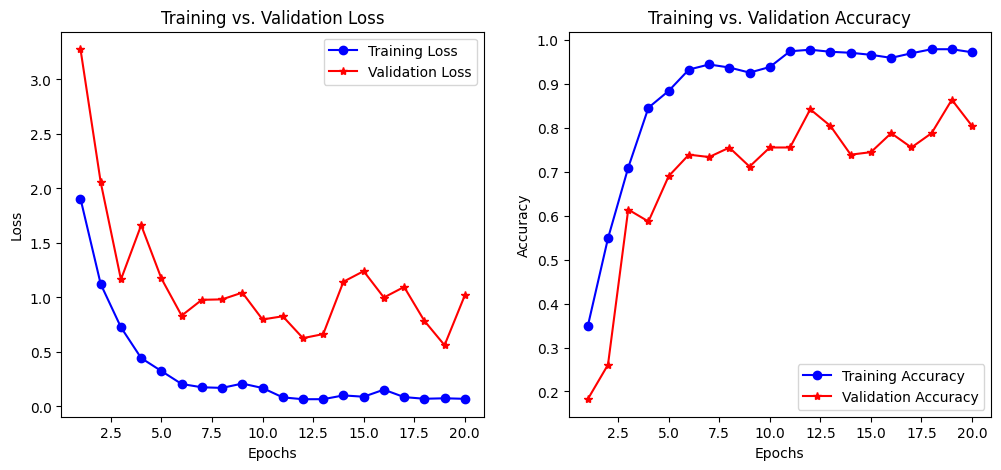

In [26]:
plot_history(history)

In [27]:
test_length = len(x_test)

loss, accuracy = model.evaluate(test_dataset, steps= test_length // BATCH_SIZE, verbose=2)
print(f"Test Accuracy: {accuracy:.4f}")

3/3 - 0s - 16ms/step - accuracy: 0.8125 - loss: 0.9750
Test Accuracy: 0.8125
